In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [0]:
train_id = pd.read_csv('/content/drive/My Drive/Data_Science/Kaggle/ka_ieee_fraud_detection/train_identity.csv')
train_tr = pd.read_csv('/content/drive/My Drive/Data_Science/Kaggle/ka_ieee_fraud_detection/train_transaction.csv')

test_id = pd.read_csv('/content/drive/My Drive/Data_Science/Kaggle/ka_ieee_fraud_detection/test_identity.csv')
test_tr = pd.read_csv('/content/drive/My Drive/Data_Science/Kaggle/ka_ieee_fraud_detection/test_transaction.csv')

In [0]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

56

In [0]:
def id_split(dataframe):
    #dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    #dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    #dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    gc.collect()
    
    return dataframe
  
def Device_name(dataframe):
    dataframe.loc[dataframe['DeviceInfo'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Moto E', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('XT1', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('M4 ', na=False), 'device_name'] = 'M4tel'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Pixel', na=False), 'device_name'] = 'Pixel'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Lenovo', na=False), 'device_name'] = 'Lenovo'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Hisense', na=False), 'device_name'] = 'Hisense'
    dataframe.loc[dataframe['DeviceInfo'].str.contains('Ilium', na=False), 'device_name'] = 'Lanix'
    gc.collect()

    return dataframe

In [0]:
train = id_split(train)
test = id_split(test)

In [0]:
# 브랜드 코드 만들기
dict = {}
train['DeviceInfo'] = train['DeviceInfo'].fillna('null')

for device in train['DeviceInfo'].unique():
    
    if device in ['ALE-L21 Build/HuaweiALE-L21', 'ALE-L23 Build/HuaweiALE-L23','BAC-L03 Build/HUAWEIBAC-L03', 'BLL-L23 Build/HUAWEIBLL-L23', 'CAM-L03 Build/HUAWEICAM-L03', 'CHC-U03 Build/HuaweiCHC-U03', 'CRO-L03 Build/HUAWEICRO-L03', 'HUAWEI', 'HUAWEI CUN-L03 Build/HUAWEICUN-L03', 'HUAWEI G7-L03 Build/HuaweiG7-L03', 'HUAWEI NXT-L09 Build/HUAWEINXT-L09', 'HUAWEI RIO-L03 Build/HUAWEIRIO-L03', 'HUAWEI TAG-L13 Build/HUAWEITAG-L13', 'HUAWEI VNS-L23 Build/HUAWEIVNS-L23', 'HUAWEI VNS-L53 Build/HUAWEIVNS-L53', 'MYA-L13 Build/HUAWEIMYA-L13', 'PRA-LX3 Build/HUAWEIPRA-LX3', 'RNE-L03 Build/HUAWEIRNE-L03', 'TRT-L53 Build/HUAWEITRT-L53', 'WAS-LX1A Build/HUAWEIWAS-LX1A', 'WAS-LX3 Build/HUAWEIWAS-LX3', 'Y635-L03 Build/HuaweiY635-L03','EVA-L09 Build/HUAWEIEVA-L09','hi6210sft Build/MRA58K']:
        dict[device] = 'Huawei'
        
    elif device in ['LG-D320 Build/KOT49I.V10a', 'LG-D331 Build/LRX22G', 'LG-D680 Build/KOT49I', 'LG-D693n Build/LRX22G', 'LG-H320 Build/LRX21Y', 'LG-H500 Build/LRX21Y', 'LG-H542 Build/MRA58K', 'LG-H650 Build/MRA58K', 'LG-H840 Build/MMB29M', 'LG-H840 Build/NRD90U', 'LG-H870 Build/NRD90U', 'LG-K200 Build/MXB48T', 'LG-K220 Build/MXB48T', 'LG-K410 Build/LRX22G', 'LG-K500 Build/MMB29M', 'LG-K530 Build/MMB29M', 'LG-K580 Build/MRA58K', 'LG-M250 Build/NRD90U', 'LG-M320 Build/NRD90U', 'LG-M400 Build/NRD90U', 'LG-M700 Build/NMF26X', 'LG-X165g Build/LRX21M', 'LG-X180g Build/LMY47I', 'LG-X210 Build/LMY47I', 'LG-X220 Build/LMY47I', 'LG-X230 Build/MRA58K', 'LG-X240 Build/MRA58K', 'LGLS676 Build/MXB48T', 'LGLS775 Build/NRD90U', 'LGMP260 Build/NRD90U', 'LGMS210 Build/NRD90U','VS425PP Build/LMY47V', 'VS5012 Build/NRD90M', 'VS987 Build/NRD90U', 'VS988 Build/NRD90U', 'VS995 Build/NRD90M']:
        dict[device] = 'LG'
        
    elif device in ['Linux x86_64']:
        dict[device] = 'Linux'
        
    elif device in ['MacOS']:
        dict[device] = 'MacOS'
        
    elif device in ['Moto', 'Moto C Build/NRD90M.063', 'Moto C Plus Build/NRD90M.05.034', 'Moto E (4) Build/NMA26.42-19', 'Moto E (4) Build/NMA26.42-69', 'Moto E (4) Plus Build/NMA26.42-69', 'Moto G (4) Build/NPJ25.93-14.5', 'Moto G (4) Build/NPJ25.93-14.7', 'Moto G (4) Build/NPJS25.93-14-10', 'Moto G (4) Build/NPJS25.93-14-13', 'Moto G (4) Build/NPJS25.93-14-15', 'Moto G (5) Build/NPP25.137-38', 'Moto G (5) Build/NPP25.137-72', 'Moto G (5) Build/NPP25.137-82', 'Moto G (5) Build/NPP25.137-93', 'Moto G (5) Build/NPPS25.137-15-11', 'Moto G (5) Plus Build/NPN25.137-72', 'Moto G (5) Plus Build/NPN25.137-82', 'Moto G (5) Plus Build/NPN25.137-92', 'Moto G (5) Plus Build/NPNS25.137-15-11', 'Moto G (5) Plus Build/NPNS25.137-92-8', 'Moto G (5S', 'Moto G Play Build/MPIS24.241-15.3-26', 'Moto G Play Build/MPIS24.241-15.3-7', 'Moto X Play Build/NPD26.48-24-1', 'Moto Z (2', 'Moto Z2 Play Build/NPSS26.118-19-14', 'MotoE2(4G-LTE', 'MotoG3 Build/MPI24.65-33.1-2', 'MotoG3 Build/MPIS24.65-33.1-2-16', 'moto x4 Build/OPWS27.57-40-6','MOT-A6020l37 Build/LMY47V','XT1032 Build/LPBS23.13-56-2', 'XT1064 Build/MPB24.65-34-3', 'XT1254 Build/MCG24.251-5-5', 'XT1585 Build/NCK25.118-10.5', 'XT1635-02 Build/NPN26.118-22-2', 'XT1650 Build/NCLS26.118-23-13-3']:
        dict[device] = 'Motolola'
        
    elif device in ['SAMSUNG', 'SAMSUNG SM-A310F Build/NRD90M', 'SAMSUNG SM-A520F Build/NRD90M', 'SAMSUNG SM-G531H Build/LMY48B', 'SAMSUNG SM-G532M Build/MMB29T', 'SAMSUNG SM-G610M Build/MMB29K', 'SAMSUNG SM-G891A Build/NRD90M', 'SAMSUNG SM-G920P Build/NRD90M', 'SAMSUNG SM-G930A Build/NRD90M', 'SAMSUNG SM-G930F Build/NRD90M', 'SAMSUNG SM-G930P Build/NRD90M', 'SAMSUNG SM-G930T Build/NRD90M', 'SAMSUNG SM-G935A Build/NRD90M', 'SAMSUNG SM-G935F Build/NRD90M', 'SAMSUNG SM-G950F Build/NRD90M', 'SAMSUNG SM-G950F Build/R16NW', 'SAMSUNG SM-G950U Build/NRD90M', 'SAMSUNG SM-G955F Build/NRD90M', 'SAMSUNG SM-G955U Build/NRD90M', 'SAMSUNG SM-J120H Build/LMY47V', 'SAMSUNG SM-J327T1 Build/NRD90M', 'SAMSUNG SM-J700M Build/MMB29K', 'SAMSUNG SM-J701M Build/NRD90M', 'SAMSUNG SM-J730GM Build/NRD90M', 'SAMSUNG SM-N950F Build/NMF26X', 'SAMSUNG SM-N950U Build/NMF26X', 'SAMSUNG-SM-G891A Build/NRD90M', 'SAMSUNG-SM-G928A Build/NRD90M', 'SAMSUNG-SM-G930A Build/NRD90M', 'SAMSUNG-SM-G935A Build/NRD90M', 'SLA-L03 Build/HUAWEISLA-L03', 'SM-A300H Build/LRX22G', 'SM-A310F Build/NRD90M', 'SM-A310M Build/LMY47X', 'SM-A320FL Build/NRD90M', 'SM-A320Y Build/NRD90M', 'SM-A500M Build/KTU84P', 'SM-A510M Build/MMB29K', 'SM-A510M Build/NRD90M', 'SM-A520F Build/NRD90M', 'SM-A720F Build/NRD90M', 'SM-E500M Build/KTU84P', 'SM-G355M Build/KOT49H', 'SM-G530H Build/KTU84P', 'SM-G530H Build/LRX22G', 'SM-G531H Build/LMY48B', 'SM-G532M Build/MMB29T', 'SM-G550T1 Build/MMB29K', 'SM-G570M Build/MMB29K', 'SM-G570M Build/NRD90M', 'SM-G610M Build/MMB29K', 'SM-G610M Build/NRD90M', 'SM-G800F Build/MMB29K', 'SM-G900M Build/LRX21T', 'SM-G900V Build/MMB29M', 'SM-G920F Build/NRD90M', 'SM-G920I Build/NRD90M', 'SM-G920P Build/NRD90M', 'SM-G920V Build/NRD90M', 'SM-G925I Build/NRD90M', 'SM-G925V Build/NRD90M', 'SM-G928G Build/NRD90M', 'SM-G928V Build/NRD90M', 'SM-G930F Build/NRD90M', 'SM-G930P Build/NRD90M', 'SM-G930T Build/NRD90M', 'SM-G930V Build/NRD90M', 'SM-G935F Build/NRD90M', 'SM-G935P Build/NRD90M', 'SM-G935T Build/NRD90M', 'SM-G935V Build/NRD90M', 'SM-G950F Build/NRD90M', 'SM-G950F Build/R16NW', 'SM-G950U Build/NRD90M', 'SM-G950U Build/R16NW', 'SM-G950U1 Build/NRD90M', 'SM-G955F Build/NRD90M', 'SM-G955F Build/R16NW', 'SM-G955U Build/NRD90M', 'SM-G955U Build/R16NW', 'SM-G9600 Build/R16NW', 'SM-G965U Build/R16NW', 'SM-J105B Build/LMY47V', 'SM-J111M Build/LMY47V', 'SM-J120H Build/LMY47V', 'SM-J200M Build/LMY47X', 'SM-J320M Build/LMY47V', 'SM-J327P Build/MMB29M', 'SM-J327T1 Build/NRD90M', 'SM-J500M Build/LMY48B', 'SM-J500M Build/MMB29M', 'SM-J510MN Build/MMB29M', 'SM-J530GM Build/NRD90M', 'SM-J700M Build/LMY48B', 'SM-J700M Build/MMB29K', 'SM-J701M Build/NRD90M', 'SM-J710MN Build/MMB29K', 'SM-J727T1 Build/NRD90M', 'SM-J730GM Build/NRD90M', 'SM-N900W8 Build/LRX21V', 'SM-N910V Build/MMB29M', 'SM-N920A Build/MMB29K', 'SM-N920T Build/NRD90M', 'SM-N920V Build/NRD90M', 'SM-N950F Build/NMF26X', 'SM-N950U Build/NMF26X', 'SM-N950U Build/R16NW', 'SM-T280 Build/LMY47V', 'SM-T350 Build/NMF26X', 'SM-T377V Build/NMF26X', 'SM-T550 Build/NMF26X', 'SM-T560 Build/KTU84P', 'SM-T580 Build/NRD90M', 'SM-T710 Build/NRD90M', 'SM-T800 Build/MMB29K', 'SM-T810 Build/NRD90M','GT-I9060M Build/KTU84P']:
        dict[device] = 'Samsung'
        
    elif device in ['rv:11.0', 'rv:31.0', 'rv:45.0', 'rv:47.0', 'rv:48.0', 'rv:51.0', 'rv:52.0', 'rv:54.0', 'rv:56.0', 'rv:57.0', 'rv:58.0', 'rv:59.0', 'rv:60.0','MDDRJS']:
        dict[device] = 'Mozilla'
    
    elif device in ['HTC Desire 10 lifestyle Build/MMB29M', 'HTC Desire 530 Build/MMB29M', 'HTC Desire 626s Build/LMY47O', 'HTC Desire 650 Build/MMB29M', 'HTC One A9s Build/MRA58K','Build/OPR6.170623.013']:
        dict[device] ='HTC'
    
    elif device in ['5010G Build/MRA58K', '5011A Build/NRD90M', '5012G Build/MRA58K', '5015A Build/LMY47I', '5025G Build/LMY47I', '5056A Build/MMB29M', '5080A Build/MRA58K', '8050G Build/LMY47I']:
        dict[device] = 'Alcatel'
    
    elif device in ['Windows','Trident/7.0','Windows NT 6.1']:
        dict[device] = 'Windows'
        
    elif device in ['iOS Device']:
        dict[device] = 'iOS Device'
        
    elif device in ['null']:
        dict[device] = 'null'
    
    elif device in ['Lenovo', 'Lenovo A2016b30 Build/MRA58K', 'Lenovo K33b36 Build/MMB29M', 'Lenovo K33b36 Build/NRD90N', 'Lenovo PB2-650Y Build/MRA58K', 'Lenovo-A6020l36 Build/LMY47V']:
        dict[device] = 'Lenovo'
        
    elif device in ['E5506 Build/29.2.A.0.166', 'E5606 Build/30.2.A.1.21', 'E6603 Build/32.4.A.1.54', 'F3113 Build/33.3.A.1.97', 'F3213 Build/36.0.A.2.146', 'F3213 Build/36.1.A.1.86', 'F3313 Build/37.0.A.2.108', 'F3313 Build/37.0.A.2.248', 'F5121 Build/34.3.A.0.238', 'F5121 Build/34.3.A.0.252', 'G3223 Build/42.0.A.4.101', 'G3313 Build/43.0.A.5.79']:
        dict[device] = 'Sony'
    
    elif device in ['Hisense F20 Build/MMB29M', 'Hisense F23 Build/NRD90M', 'Hisense L675 Build/MRA58K', 'Hisense U963 Build/MRA58K']:
        dict[device] = 'Hisense'
        
    elif device in ['Ilium L910 Build/MRA58K', 'Ilium LT510 Build/MRA58K', 'Ilium X510 Build/MRA58K', 'Ilium X710 Build/MRA58K']:
        dict[device] = 'Lanix'
        
    elif device in ['KFDOWI Build/LVY48F', 'KFFOWI Build/LVY48F', 'KFGIWI Build/LVY48F']:
        dict[device] = 'Amazon'
        
    elif device in ['Redmi 4X Build/N2G47H', 'Redmi Note 4 Build/NRD90M']:
        dict[device] = 'Xiaomi'
    
    elif device in ['Pixel', 'Pixel Build/OPM1.171019.011', 'Pixel XL Build/OPM1.171019.011','Nexus']:
        dict[device] = 'Pixel'
    
    elif device in ['Z835 Build/NMF26V', 'Z981 Build/MMB29M','BLADE A520 Build/NRD90M', 'BLADE V8 SE Build/NRD90M',  'Blade A510 Build/MRA58K', 'Blade L2 Plus Build/KOT49H', 'Blade L5 Build/LMY47I', 'Blade V580 Build/LMY47D', 'Blade V6 Build/LRX22G', 'Blade V6 Max Build/MRA58K', 'Blade V6 Plus Build/MRA58K']:
        dict[device] = 'ZTE'
    elif device in ['TA-1038 Build/NMF26O', 'TA-1039 Build/NMF26F']:
        dict[device] = 'Nokia'
    elif device in ['M4 SS4453 Build/MMB29M', 'M4 SS4456 Build/LMY47V']:
        dict[device] = 'M4tel'
    #else:
    #    dict[device] = 'Others'
        
train['device_name'] = train['DeviceInfo'].map(dict)

test['DeviceInfo'] = test['DeviceInfo'].fillna('null')

test['device_name'] = test['DeviceInfo'].map(dict)


In [0]:
train = Device_name(train)
test = Device_name(test)

In [0]:
# DeviceInfo 소수 value는 Others로 바꾸기

train['device_count'] = train.groupby(['DeviceInfo'])['DeviceInfo'].transform('count')
train['DeviceInfo'] = np.where(train['device_count']<=2, 'Others', train['DeviceInfo'])

test['device_count'] = train.groupby(['DeviceInfo'])['DeviceInfo'].transform('count')
test['DeviceInfo'] = np.where(test['device_count']<=2, 'Others', test['DeviceInfo'])

In [0]:
# 결제금액 - 당일 결제금액 평균 혹은 중간값
train['days_for_amt'] = (train['TransactionDT'] - 86400) // 86400
train['days_mean_amt'] = train['TransactionAmt'] - train.groupby(['days_for_amt'])['TransactionAmt'].transform('mean')
del train['days_for_amt']

test['days_for_amt'] = (test['TransactionDT'] - 86400) // 86400
test['days_mean_amt'] = test['TransactionAmt'] - test.groupby(['days_for_amt'])['TransactionAmt'].transform('mean')

del test['days_for_amt']

In [0]:
# hour, day

train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [0]:
# 결제금액 - 해당 상품 결제금액 평균 혹은 중간값

train['CD_Amt_diff'] = train['TransactionAmt'] - train.groupby(['ProductCD'])['TransactionAmt'].transform('mean')

test['CD_Amt_diff'] = test['TransactionAmt'] - test.groupby(['ProductCD'])['TransactionAmt'].transform('mean')

In [0]:
# 카드 구분 컬럼
# 사기 거래 중 카드 거래 횟수 1인 경우 비율 :  0.8392554991539763

train['Card_id_count'] =  train.groupby(['card1','card2','card3','card4','card5','card6', 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10', 'C11'])['TransactionID'].transform('count')
                                        
train['unique_card_id'] = np.where(train['Card_id_count']==1, 1 , 0)
                                        
                                        
test['Card_id_count'] =  test.groupby(['card1','card2','card3','card4','card5','card6', 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10', 'C11'])['TransactionID'].transform('count')
                                        
test['unique_card_id'] = np.where(test['Card_id_count']==1, 1, 0)
                                          

In [0]:
train['nulls'] = train.isnull().sum(axis=1)
test['nulls'] = test.isnull().sum(axis=1)

In [0]:
useful_cols = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
               'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 
               'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5',
               'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 
               'V18', 'V19', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'V30', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
               'V40', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 
               'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 
               'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 
               'V99', 'V100', 'V101', 'V102', 'V103', 'V105', 'V106', 'V108', 'V109', 'V110', 'V112', 'V115', 'V121', 'V123', 'V124', 'V125', 
               'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V139', 'V140', 'V143', 'V144', 
               'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V157', 'V158', 'V159', 'V160', 'V162', 'V163', 
               'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 
               'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V192', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 
               'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 
               'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 
               'V236', 'V237', 'V238', 'V239', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V253', 'V254', 
               'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 
               'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 
               'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V303', 'V304', 
               'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 
               'V322', 'V323', 'V324', 'V326', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 
               'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 
               'id_19', 'id_20', 'id_21', 'id_23', 'id_24', 'id_25', 'id_26', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_36', 'id_37', 'id_38', 
               'DeviceType', 'DeviceInfo', 'device_name', 'days_mean_amt']

In [0]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# Count encoding for card1 feature.  https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
# Explained in this kernel:
train['card1_count_full'] = train['card1'].map(train['card1'].value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(test['card1'].value_counts(dropna=False))


# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
for feature in ['id_34', 'id_36']:
    if feature in useful_cols:
        # Count encoded for both train and test
        train[feature + '_count_full'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_full'] = test[feature].map(test[feature].value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    if feature in useful_cols:
        # Count encoded separately for train and test
        train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [0]:
additional_cols = ['device_version','OS_id_30', 'version_id_30', 'browser_id_31','version_id_31','Transaction_day_of_week','Transaction_hour','CD_Amt_diff','unique_card_id','TransactionAmt_decimal', 'card1_count_full', 'id_02__id_20',
       'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain',
       'P_emaildomain__C2', 'card2__dist1', 'card1__card5', 'card2__id_20',
       'card5__P_emaildomain', 'addr1__card1', 'id_34_count_full',
       'id_36_count_full', 'id_01_count_dist', 'id_31_count_dist',
       'id_33_count_dist', 'id_36_count_dist','nulls','Card_id_count']


all_cols = useful_cols + additional_cols

In [0]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]


cols_to_drop = list(set(one_value_cols + one_value_cols_test))

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)+1))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

train = train.drop('C13', axis=1) # C13은 테스트에서 결측 비율 90% 이상이라 제거
test = test.drop('C13', axis=1)

2 features are going to be dropped for being useless


In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
for col in tqdm_notebook(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [0]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,device_name,device_count,days_mean_amt,Transaction_day_of_week,Transaction_hour,CD_Amt_diff,Card_id_count,unique_card_id,nulls,TransactionAmt_decimal,card1_count_full,id_02__id_20,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_34_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist
0,3663549,18403224,31.95,9,10409,111.0,150.0,9,226.0,7,170.0,87.0,1.0,NaN,76,93,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,...,651,5,5,5,5,5,5,3335,604,14,89,49,82,51,471874,-110.205095,2.0,0.0,-122.213752,5.0,0,214,949,75,270749,259912,124,8033,2401,807,482,372,1375,5275,434516,369714,364784,370066,436020,369714
1,3663550,18403263,49.00,9,4272,111.0,150.0,9,226.0,7,299.0,87.0,4.0,NaN,62,93,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,...,651,5,5,5,5,5,5,3335,604,14,89,49,82,51,471874,-93.155095,2.0,0.0,-105.163752,19.0,0,216,0,961,270749,259912,602,8019,764,1646,12585,372,1361,26707,434516,369714,364784,370066,436020,369714
2,3663551,18403310,171.00,9,4476,574.0,150.0,9,226.0,7,472.0,87.0,2635.0,NaN,79,93,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,136.0,...,651,5,5,5,5,5,5,3335,604,14,89,49,82,51,471874,28.844905,2.0,0.0,16.836248,1.0,1,212,0,33,270749,259912,49,8036,3027,29576,12800,8705,1378,46662,434516,369714,364784,370066,436020,369714
3,3663552,18403310,284.95,9,10989,360.0,150.0,9,166.0,7,205.0,87.0,17.0,NaN,76,93,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,242.0,...,651,5,5,5,5,5,5,3335,604,14,89,49,82,51,471874,142.794905,2.0,0.0,130.786248,2.0,0,217,949,839,270749,259912,167,8033,1945,15605,1163,4408,730,14266,434516,369714,364784,370066,436020,369714
4,3663553,18403317,67.95,9,18018,452.0,150.0,7,117.0,7,264.0,87.0,6.0,NaN,76,93,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,...,651,5,5,5,5,5,5,3335,604,14,89,49,82,51,9,-74.205095,2.0,0.0,-86.213752,4.0,0,214,950,1217,270749,259912,142,8033,2401,19935,9503,6030,142,20532,434516,369714,364784,370066,436020,369714


In [0]:
for col in tqdm_notebook(test.columns): 
    if test[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [0]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 591.63 Mb (72.0% reduction)
Mem. usage decreased to 498.20 Mb (72.2% reduction)


In [0]:
X = train.sort_values('TransactionDT')[all_cols]
y = train.sort_values('TransactionDT')['isFraud']
test = test[all_cols]

In [0]:
gc.collect()

42

------------------

In [0]:
# 일단 비교를 위해 0929_1의 파라미터로 변수의 효용을 비교해본다

In [0]:
params = {'bagging_fraction': 0.3996,
 'feature_fraction': 0.8606,
 'learning_rate': 0.07347,
 'max_depth': 30,
 'min_child_weight': 0.001569,
 'min_data_in_leaf': 48,
 'neg_bagging_fraction': 0.05808,
 'num_leaves': 437,
 'pos_bagging_fraction': 0.6011,
 'reg_alpha': 1.708,
 'reg_lambda':1.021,
 'is_unbalance': True}

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47


In [0]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[106]	training's auc: 0.999998	valid_1's auc: 0.896131
Fold 1 finished in 0:01:02.524801
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[80]	training's auc: 0.999466	valid_1's auc: 0.915692
Fold 2 finished in 0:02:26.618820
Training on fold 3
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[147]	training's auc: 0.999951	valid_1's auc: 0.90697
Fold 3 finished in 0:04:20.214239
Training on fold 4
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[193]	training's auc: 0.999952	valid_1's auc: 0.931287
Fold 4 finished in 0:06:53.340317
Training on fold 5
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[286]	training's auc: 0.999988	valid_1's auc: 0.926804
Fold 5

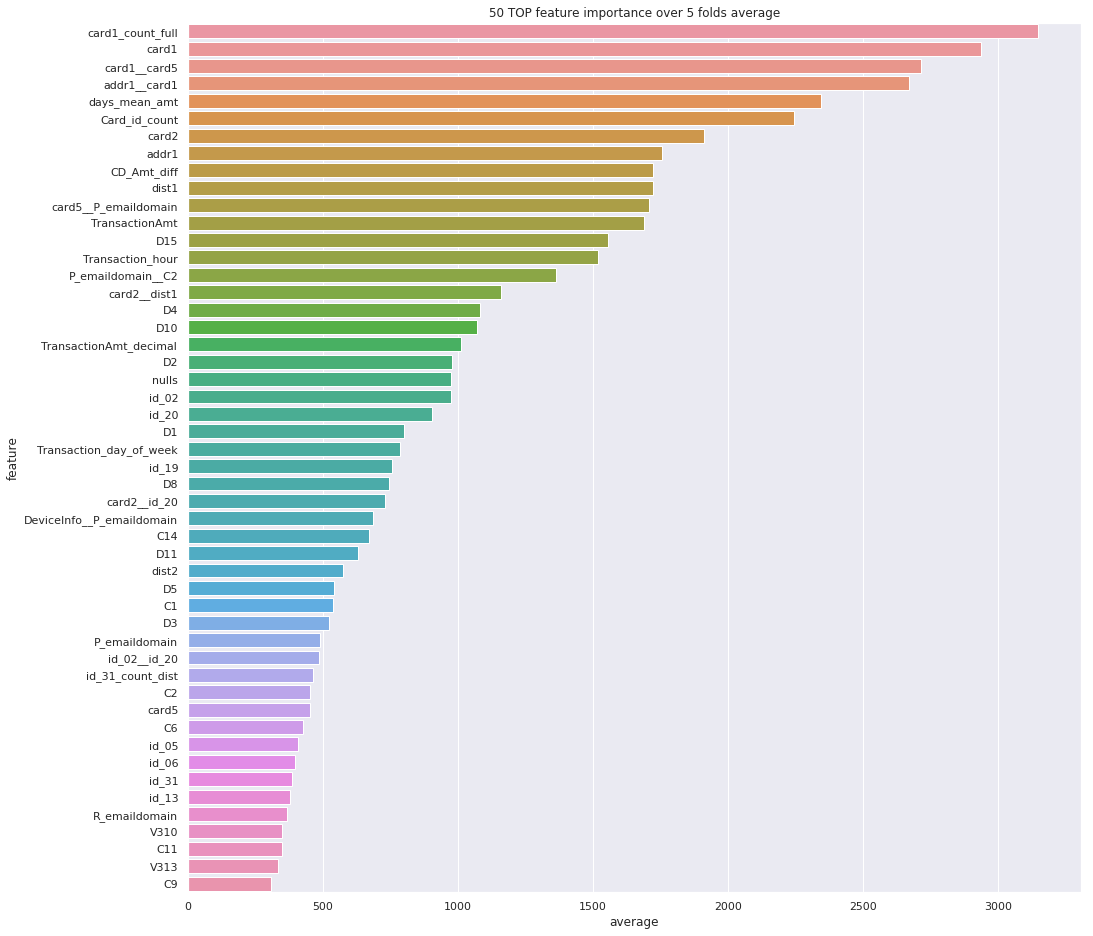

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
# 'is_unbalance': True
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[112]	training's auc: 1	valid_1's auc: 0.884362
Fold 1 finished in 0:01:12.920090
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[181]	training's auc: 1	valid_1's auc: 0.899018
Fold 2 finished in 0:03:12.789235
Training on fold 3
Training until validation scores don't improve for 500 rounds.


KeyboardInterrupt: ignored

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

-----------------

In [0]:
# 변수 추가한 거에 베이지안 opt 해보기

In [0]:
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda,
    learning_rate,
    neg_bagging_fraction,
    pos_bagging_fraction,
    num_iterations,
    max_bin
    #subsample_freq
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': int(round(num_leaves)), 
              'min_data_in_leaf': int(round(min_data_in_leaf)),
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': int(round(max_depth)),
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              #'subsample_freq ': subsample_freq,
              'pos_bagging_fraction':pos_bagging_fraction,
              'neg_bagging_fraction':neg_bagging_fraction, 
              'num_iterations' : num_iterations,
              'max_bin': max_bin,
              'objective': 'binary',
              'save_binary': True,
              'seed': 42,
              'feature_fraction_seed': 42,
              'bagging_seed': 42,
              'drop_seed': 42,
              'data_random_seed': 42,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': True,
              'boost_from_average': True,
              'metric':'auc'}    
    
    
    
    cv_result = lgb.cv(param, train_data, nfold= 5, seed= 42, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [0]:
!pip install Bayesian-Optimization

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (1, 500), 
    'min_data_in_leaf': (100, 1000),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.01, 0.0001),
    'min_child_weight': (0.0001, 10),   
    'reg_alpha': (0.00001, 2), 
    'reg_lambda': (0.00001, 2),
    'max_depth':(0,70),
    #'subsample_freq ': (0.1, 0.9),
    'pos_bagging_fraction':(0,1),
    'neg_bagging_fraction':(0,1),
    'num_iterations' : (10000.20000),
    'max_bin': (15,100)

}

In [0]:
from bayes_opt import BayesianOptimization

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [0]:
train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)

In [0]:
init_points = 10
n_iter = 15

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | neg_ba... | num_le... | pos_ba... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  26       |  0.8988   |  0.3318   |  0.229    |  0.000796 |  56.57    |  6.334    |  884.3    |  0.8037   |  131.4    |  0.8926   |  1.079    |  1.615    |
|  27       |  0.8577   |  0.8169   |  0.3544   |  0.00891  |  15.96    |  4.271    |  836.2    |  0.8607   |  5.86     |  0.5107   |  0.8348   |  0.4442   |
|  28       |  0.9136   |  0.1959   |  0.3701   |  0.000665 |  22.62    |  5.188    |  732.7    |  0.3636   |  680.3    |  0.9624   |  0.5036   |  0.9945   |
|  29       |  0.9431   |  0.3407   |  0.3279   |  0.009635 |  42.67    |  5.02

In [0]:
LGB_BO.max['params']

{'bagging_fraction': 0.6199167862092227,
 'feature_fraction': 0.8113433347197863,
 'learning_rate': 0.01,
 'max_depth': 67.16154414015763,
 'min_child_weight': 1.04861569271472,
 'min_data_in_leaf': 114.04555939297234,
 'neg_bagging_fraction': 0.7691907338037487,
 'num_leaves': 636.0565157257234,
 'pos_bagging_fraction': 0.8671182893146449,
 'reg_alpha': 1.473309593478941,
 'reg_lambda': 1.6709623173107975}

In [0]:
params = {'bagging_fraction': 0.6199167862092227,
 'feature_fraction': 0.8113433347197863,
 'learning_rate': 0.01,
 'max_depth': 67,
 'min_child_weight': 1.04861569271472,
 'min_data_in_leaf': 114,
 'neg_bagging_fraction': 0.7691907338037487,
 'num_leaves': 636,
 'pos_bagging_fraction':0.8671182893146449,
 'reg_alpha': 1.473309593478941,
 'reg_lambda':1.6709623173107975}

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47
params['is_unbalance'] = 'True'

In [0]:
# params['is_unbalance'] = 'True'
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 1	valid_1's auc: 0.901753
Early stopping, best iteration is:
[938]	training's auc: 1	valid_1's auc: 0.901679
Fold 1 finished in 0:04:25.208015
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999995	valid_1's auc: 0.91454
Early stopping, best iteration is:
[1030]	training's auc: 0.999996	valid_1's auc: 0.91461
Fold 2 finished in 0:10:24.012645
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999992	valid_1's auc: 0.91084
Early stopping, best iteration is:
[1050]	training's auc: 0.999994	valid_1's auc: 0.910955
Fold 3 finished in 0:17:48.038423
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999957	valid_1's auc: 0.928013
[2000]	training's auc: 1	valid_1's auc: 0.930431
Early stopping, best iteration is:
[1993]	

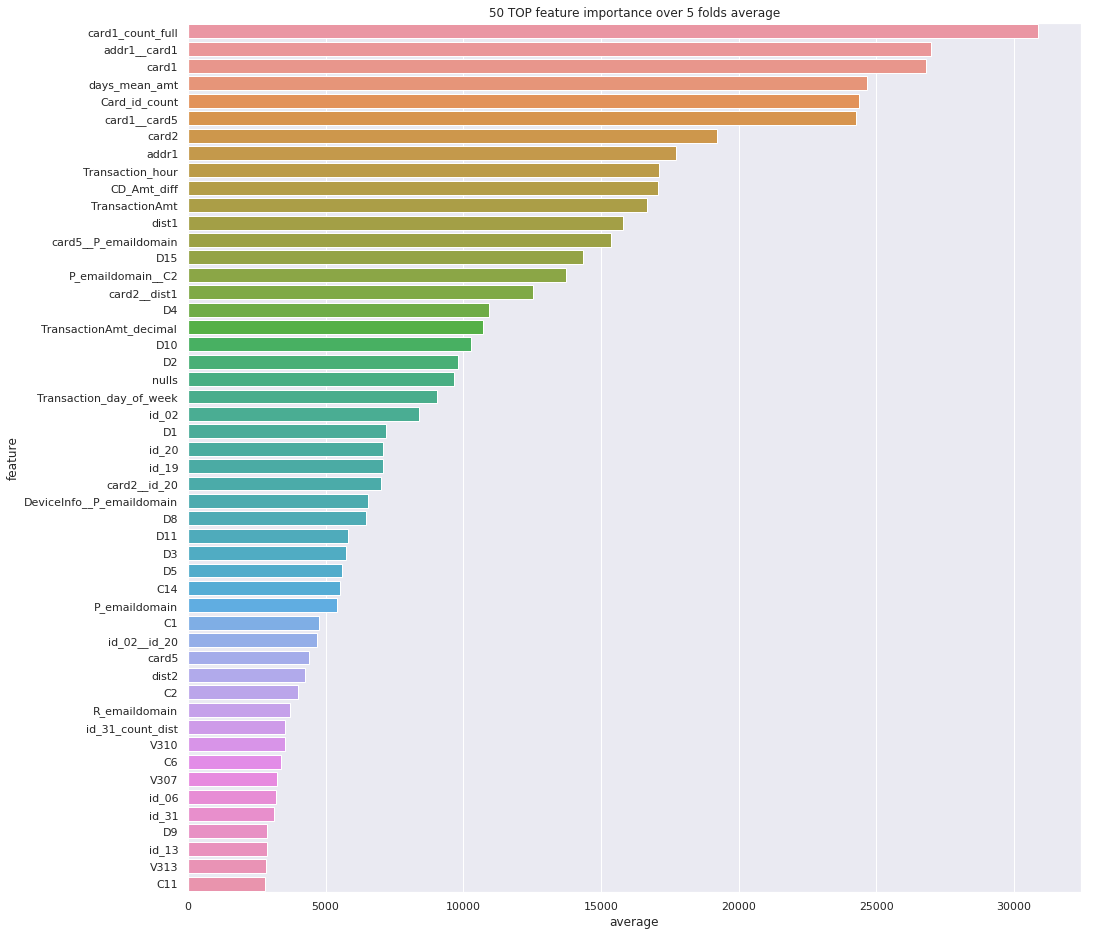

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
# 학습률만 낮춰보자
params = {'bagging_fraction': 0.6199167862092227,
 'feature_fraction': 0.8113433347197863,
 'learning_rate': 0.005,
 'max_depth': 67,
 'min_child_weight': 1.04861569271472,
 'min_data_in_leaf': 114,
 'neg_bagging_fraction': 0.7691907338037487,
 'num_leaves': 636,
 'pos_bagging_fraction':0.8671182893146449,
 'reg_alpha': 1.473309593478941,
 'reg_lambda':1.6709623173107975}

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47
params['is_unbalance'] = 'True'


folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999923	valid_1's auc: 0.899978
[2000]	training's auc: 1	valid_1's auc: 0.902688
Early stopping, best iteration is:
[1844]	training's auc: 1	valid_1's auc: 0.902647
Fold 1 finished in 0:07:07.881580
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999783	valid_1's auc: 0.911916
[2000]	training's auc: 0.999995	valid_1's auc: 0.91546
Early stopping, best iteration is:
[1992]	training's auc: 0.999995	valid_1's auc: 0.915472
Fold 2 finished in 0:17:03.588161
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999577	valid_1's auc: 0.909256
[2000]	training's auc: 0.999991	valid_1's auc: 0.911112
Early stopping, best iteration is:
[2184]	training's auc: 0.999995	valid_1's auc: 0.911245
Fold 3 finished in 0:29:51.868939
Training on fold 4
Training until validation scores don't 

In [0]:


params = {'bagging_fraction': 0.2905699849522282,
 'feature_fraction': 0.5640049436665598,
 'learning_rate': 0.01,
 'max_depth': 49,
 'min_child_weight': 0.0001462051986391895,
 'min_data_in_leaf': 13,
 'neg_bagging_fraction': 0.9803878600118235,
 'num_leaves': 799,
 'pos_bagging_fraction': 0.4873081206682075,
 'reg_alpha': 0.2899933980319331,
 'reg_lambda':1.8674148568255589}

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47
params['is_unbalance'] = 'True'

In [0]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 1	valid_1's auc: 0.902097
Early stopping, best iteration is:
[729]	training's auc: 1	valid_1's auc: 0.902214
Fold 1 finished in 0:03:35.491040
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[488]	training's auc: 0.999932	valid_1's auc: 0.923925
Fold 2 finished in 0:06:18.688671
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 1	valid_1's auc: 0.915139
Early stopping, best iteration is:
[871]	training's auc: 0.999999	valid_1's auc: 0.915495
Fold 3 finished in 0:13:45.014755
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999998	valid_1's auc: 0.936052
Early stopping, best iteration is:
[769]	training's auc: 0.999952	valid_1's auc: 0.936166
Fold 4 finished in 0:18:07.680254
Training on fold 5
Training u

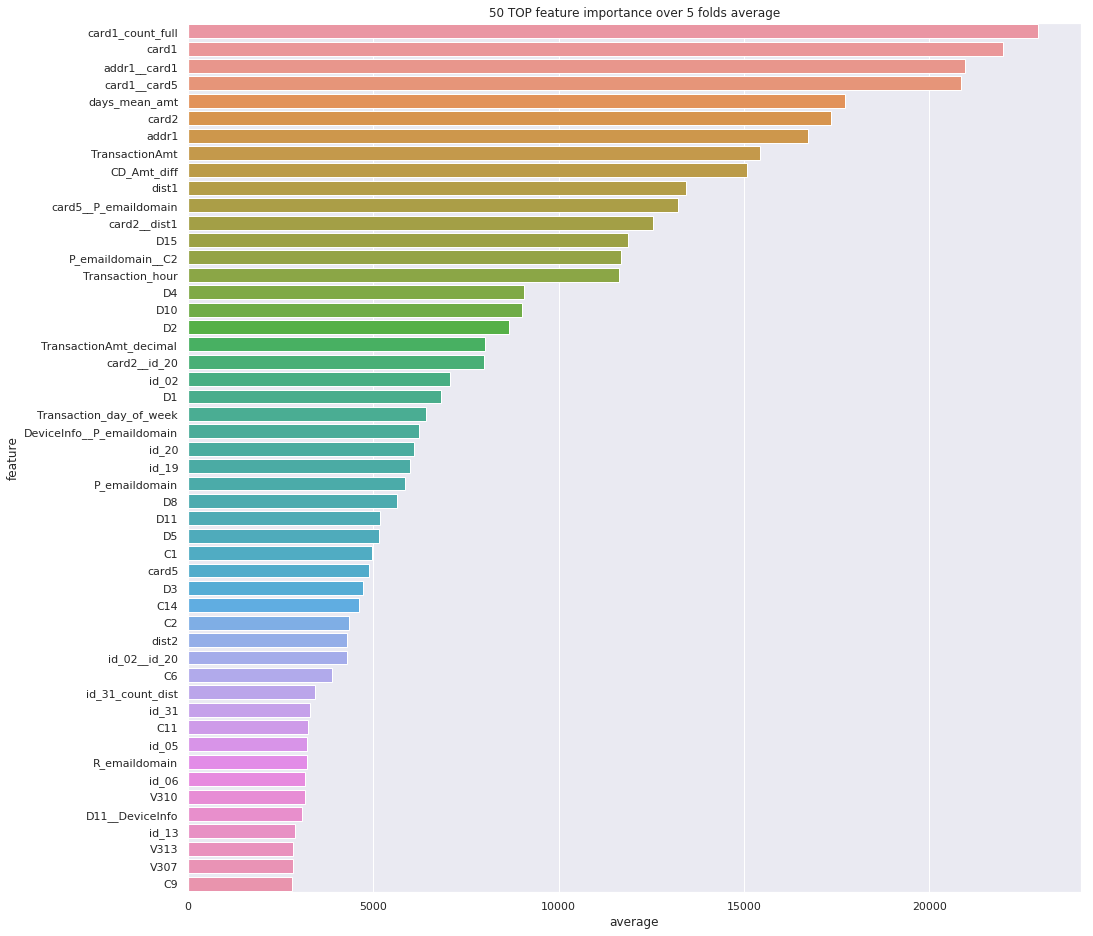

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

--------------

In [0]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[91]	training's auc: 0.999918	valid_1's auc: 0.890508
Fold 1 finished in 0:00:50.044036
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[93]	training's auc: 0.999479	valid_1's auc: 0.913433
Fold 2 finished in 0:02:04.057246
Training on fold 3
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[80]	training's auc: 0.996791	valid_1's auc: 0.905475
Fold 3 finished in 0:03:36.242760
Training on fold 4
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[105]	training's auc: 0.996676	valid_1's auc: 0.926039
Fold 4 finished in 0:05:35.257502
Training on fold 5
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[144]	training's auc: 0.997577	valid_1's auc: 0.925599
Fold 5 

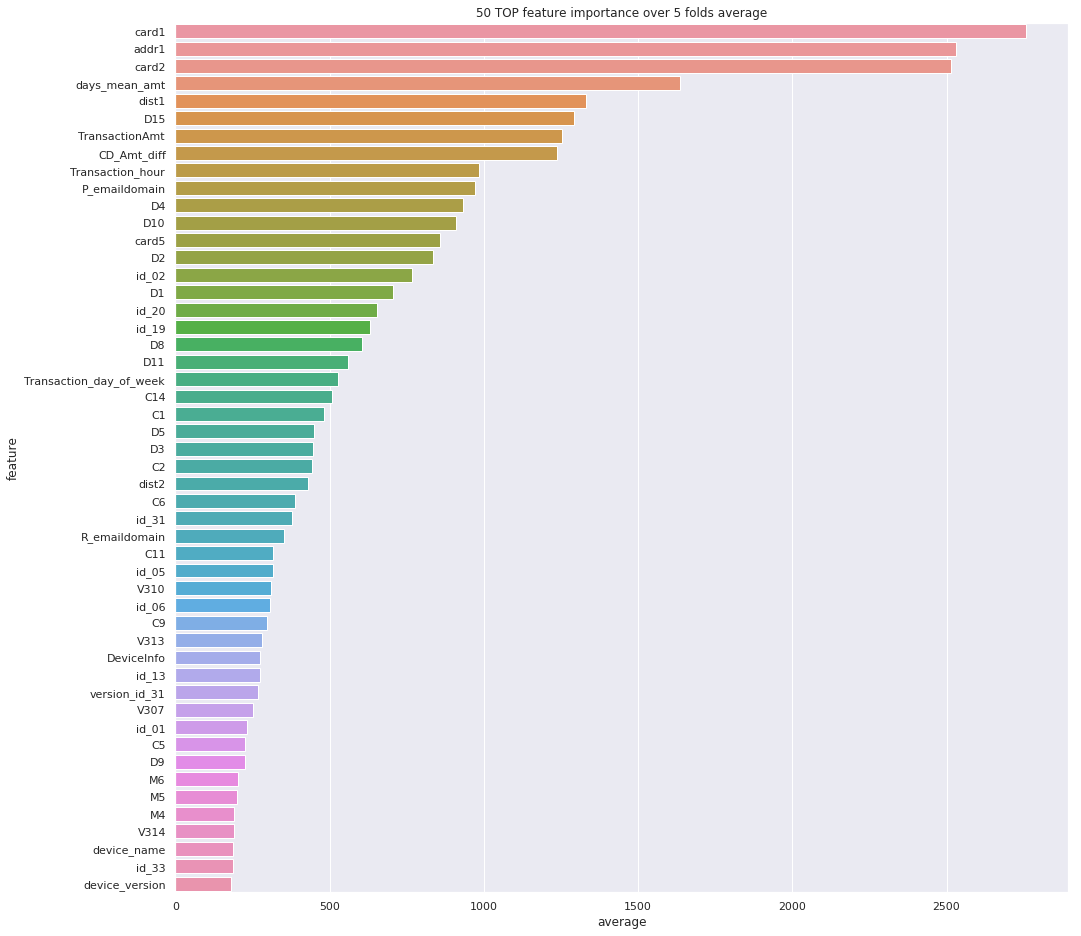

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

--------------------

In [0]:
sub = pd.read_csv('/content/drive/My Drive/ieee_fraud_detection/sample_submission.csv')

In [0]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

In [0]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.2905699849522282, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0,
               feature_fraction=0.5640049436665598, importance_type='split',
               learning_rate=0.01, max_depth=49, metric='auc',
               min_child_samples=20, min_child_weight=0.0001462051986391895,
               min_data_in_leaf=13, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, neg_bagging_fraction=0.9803878600118235,
               num_boost_round=790, num_leaves=799, objective='binary',
               pos_bagging_fraction=0.4873081206682075, random_state=47,
               reg_alpha=0.2899933980319331, reg_lambda=1.8674148568255589,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [0]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]

In [0]:
sub.to_csv('/content/drive/My Drive/ieee_fraud_detection/ieee_cis_fraud_detection_0929_3.csv', index=False)